## Libraries

In [30]:
!pip install -q mrjob nltk

## Task Solution

In [3]:
ls ../data

MR1/  MR3/                           SW_EpisodeIV.txt  SW_EpisodeVI.txt
MR2/  PrinciplesOfLazersZvelto.pdf*  SW_EpisodeV.txt   rubrics.json


In [4]:
path_to_txt = "../data/SW_EpisodeIV.txt"

In [5]:
with open(path_to_txt, "r") as fo:
    exp = fo.readlines()

In [25]:
line = exp[13]

In [52]:
_, chr_name, words = line.split('" "')

In [27]:
print(words)

We intercepted no transmissions. Aaah...  This is a consular ship. Were on a diplomatic mission."



In [42]:
import nltk
import re

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [43]:
print(words)

we intercepted no transmissions. aaah... this is a consular ship. were on a diplomatic mission."


In [127]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

st = SnowballStemmer('english')
stop_words = set(stopwords.words('english'))

In [132]:
_, chr_name, words = line.split('" "')

In [133]:
words = words.lower().strip()
words = re.sub(' +', ' ', words) # Remove extra spaces
# Remove stop words, punctuation and grammar
words = [st.stem(w) for w in word_tokenize(words) if w.isalnum() and w not in stop_words]
words = list(nltk.bigrams(words))

In [135]:
print(words)

[('intercept', 'transmiss'), ('transmiss', 'aaah'), ('aaah', 'consular'), ('consular', 'ship'), ('ship', 'diplomat'), ('diplomat', 'mission')]


### MapRed Job

In [159]:
%%file most_frequent_bigrams.py

from collections import defaultdict
import re
from operator import itemgetter

from mrjob.job import MRJob
from mrjob.step import MRStep

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer

class MR20MostFrequentBigrams(MRJob):

    def init_get_counts(self):
        """Define text processing pipeline."""
        nltk.download('punkt')
        nltk.download('stopwords')        
        self.st = SnowballStemmer('english')
        self.stop_words = set(stopwords.words('english'))

        self.counts = defaultdict(int)
    
    def get_counts(self, _, line):
        try:
            _, chr_name, words = line.split('" "')
            bigrams = nltk.bigrams(
                [self.st.stem(w) for w in word_tokenize(
                    re.sub(' +', ' ', words.lower().strip())
                    ) if w.isalnum() and w not in self.stop_words
                ]
            )
            for bigram in bigrams:
                self.counts[bigram] += 1
        except ValueError:
            # Trigger first bad excess line
            pass

    def final_get_counts(self):
        for bigram, count in self.counts.items():
            yield bigram, count

    def sum_counts(self, bigrams, counts):
        # Key to None to have output as the list of tuples
        yield None, (bigrams, sum(counts))

    def select_top_20(self, _, pairs):
        sorted_pairs = sorted(pairs, reverse=True, key=itemgetter(1))
        for pair in sorted_pairs[:20]:
            yield pair

    def steps(self):
        return [MRStep(mapper_init=self.init_get_counts,
                       mapper=self.get_counts,
                       mapper_final=self.final_get_counts,
                       reducer=self.sum_counts,
                      ),
               MRStep(reducer=self.select_top_20)
               ]

if __name__ == '__main__':
    MR20MostFrequentBigrams.run()

Overwriting most_frequent_bigrams.py


## Test locally

In [160]:
!python3 most_frequent_bigrams.py "../data/SW_EpisodeIV.txt"

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/most_frequent_bigrams.root.20231129.220315.279302
Running step 1 of 2...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk

## Running on the cluster

### Put the data on the cluster

In [230]:
!hadoop fs -ls /

Found 4 items
drwxr-xr-x   - root supergroup          0 2023-11-29 18:55 /MR_data
drwxr-xr-x   - root supergroup          0 2023-11-28 21:33 /book
drwx-wx-wx   - root supergroup          0 2023-11-28 21:21 /tmp
drwxr-xr-x   - root supergroup          0 2023-11-28 21:21 /user


In [152]:
!hadoop fs -mkdir /MR_data3

In [233]:
!hadoop fs -put -f ../data/SW_EpisodeIV.txt /MR_data && \
 hadoop fs -put -f ../data/SW_EpisodeV.txt /MR_data && \
 hadoop fs -put -f ../data/SW_EpisodeVI.txt /MR_data

### Let's go

In [161]:
%%file config.conf

runners:
  hadoop: # also works for emr runner
    setup:
        'pip install nltk'

Overwriting config.conf


Test with one file

In [194]:
!python3 most_frequent_bigrams.py -r hadoop hdfs:///MR_data/SW_EpisodeIV.txt --conf-path config.conf --output /MR_data3/outputIV

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/most_frequent_bigrams.root.20231129.222744.011982
uploading working dir files to hdfs:///user/root/tmp/mrjob/most_frequent_bigrams.root.20231129.222744.011982/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/most_frequent_bigrams.root.20231129.222744.011982/files/
Running step 1 of 2...
  packageJobJar: [/tmp/hadoop-unjar865823708295853994/] [] /tmp/streamjob8746839876952950573.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.21.0.3:8032
  Connecting to ResourceManager at resourcemanager/172.21.0.3:8032
  Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1701267673176_0070
  Total input files to process : 1
  number of splits:2
  Sub

In [195]:
!hadoop fs -cat /MR_data3/outputIV/part-00000

["rebel", "base"]	11
["r2", "unit"]	11
["sand", "peopl"]	10
["look", "like"]	10
["battl", "station"]	10
["luke", "luke"]	9
["let", "go"]	8
["uncl", "owen"]	7
["lord", "vader"]	7
["come", "back"]	7
["red", "leader"]	6
["old", "man"]	6
["yes", "sir"]	5
["tractor", "beam"]	5
["red", "five"]	5
["know", "talk"]	5
["help", "kenobi"]	5
["go", "get"]	5
["death", "star"]	5
["ben", "kenobi"]	5


Run the rest

In [187]:
!python3 most_frequent_bigrams.py -r hadoop hdfs:///MR_data/SW_EpisodeV.txt --conf-path config.conf --output /MR_data3/outputV && \
 python3 most_frequent_bigrams.py -r hadoop hdfs:///MR_data/SW_EpisodeVI.txt --conf-path config.conf --output /MR_data3/outputVI && \
 python3 most_frequent_bigrams.py -r hadoop hdfs:///MR_data/SW_EpisodeIV.txt \
                                            hdfs:///MR_data/SW_EpisodeV.txt \
                                            hdfs:///MR_data/SW_EpisodeVI.txt --conf-path config.conf --output /MR_data3/outputALL

Looking for hadoop binary in /opt/hadoop/bin...
Found hadoop binary: /opt/hadoop/bin/hadoop
Using Hadoop version 3.3.6
Looking for Hadoop streaming jar in /opt/hadoop...
Found Hadoop streaming jar: /opt/hadoop/share/hadoop/tools/lib/hadoop-streaming-3.3.6.jar
Creating temp directory /tmp/most_frequent_bigrams.root.20231129.222320.594191
uploading working dir files to hdfs:///user/root/tmp/mrjob/most_frequent_bigrams.root.20231129.222320.594191/files/wd...
Copying other local files to hdfs:///user/root/tmp/mrjob/most_frequent_bigrams.root.20231129.222320.594191/files/
Running step 1 of 2...
  packageJobJar: [/tmp/hadoop-unjar4072192335897578207/] [] /tmp/streamjob5962007062223760731.jar tmpDir=null
  Connecting to ResourceManager at resourcemanager/172.21.0.3:8032
  Connecting to ResourceManager at resourcemanager/172.21.0.3:8032
  Disabling Erasure Coding for path: /tmp/hadoop-yarn/staging/root/.staging/job_1701267673176_0064
  Total input files to process : 1
  number of splits:2
  Su

## Collect Data Result

In [165]:
!pip install -q pandas matplotlib

In [196]:
!hadoop fs -get -f /MR_data3/outputIV/part-00000  ../data/MR3/outputIV.txt && \
 hadoop fs -get -f /MR_data3/outputV/part-00000  ../data/MR3/outputV.txt && \
 hadoop fs -get -f /MR_data3/outputVI/part-00000  ../data/MR3/outputVI.txt && \
 hadoop fs -get -f /MR_data3/outputALL/part-00000  ../data/MR3/outputALL.txt

In [197]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

In [198]:
path_to_data = "../data/MR3"

files = os.listdir(path_to_data)

In [199]:
def mysplit(s):
    head = s.rstrip('0123456789')
    tail = s[len(head):]
    return head[:-1], tail

In [206]:
data

[('[rebel, base]', '11'),
 ('[r2, unit]', '11'),
 ('[sand, peopl]', '10'),
 ('[look, like]', '10'),
 ('[battl, station]', '10'),
 ('[luke, luke]', '9'),
 ('[let, go]', '8'),
 ('[uncl, owen]', '7'),
 ('[lord, vader]', '7'),
 ('[come, back]', '7'),
 ('[red, leader]', '6'),
 ('[old, man]', '6'),
 ('[yes, sir]', '5'),
 ('[tractor, beam]', '5'),
 ('[red, five]', '5'),
 ('[know, talk]', '5'),
 ('[help, kenobi]', '5'),
 ('[go, get]', '5'),
 ('[death, star]', '5'),
 ('[ben, kenobi]', '5')]

In [205]:
dfs = []
dfs_names = []
for file in files:
    with open(os.path.join(path_to_data, file), "r") as fo:
        data = fo.read().replace("\t", " ").split("\n")
    data = [mysplit(item.replace('"', '')) for item in data[:-1]]
    
    df = pd.DataFrame(data, columns=["Character", "Counts"])
    df.Counts = df.Counts.astype(int)
    
    dfs.append(df)
    dfs_names.append(file.split(".")[0])

In [207]:
# Example
pd.concat([dfs[0].head(), dfs[0].tail()])

,Character,Counts
0,"[lord, vader]",26
1,"[master, luke]",23
2,"[dark, side]",20
3,"[let, go]",18
4,"[luke, luke]",16
15,"[go, get]",10
16,"[yes, lord]",10
17,"[take, care]",10
18,"[star, destroy]",10
19,"[sand, peopl]",10


## EDA

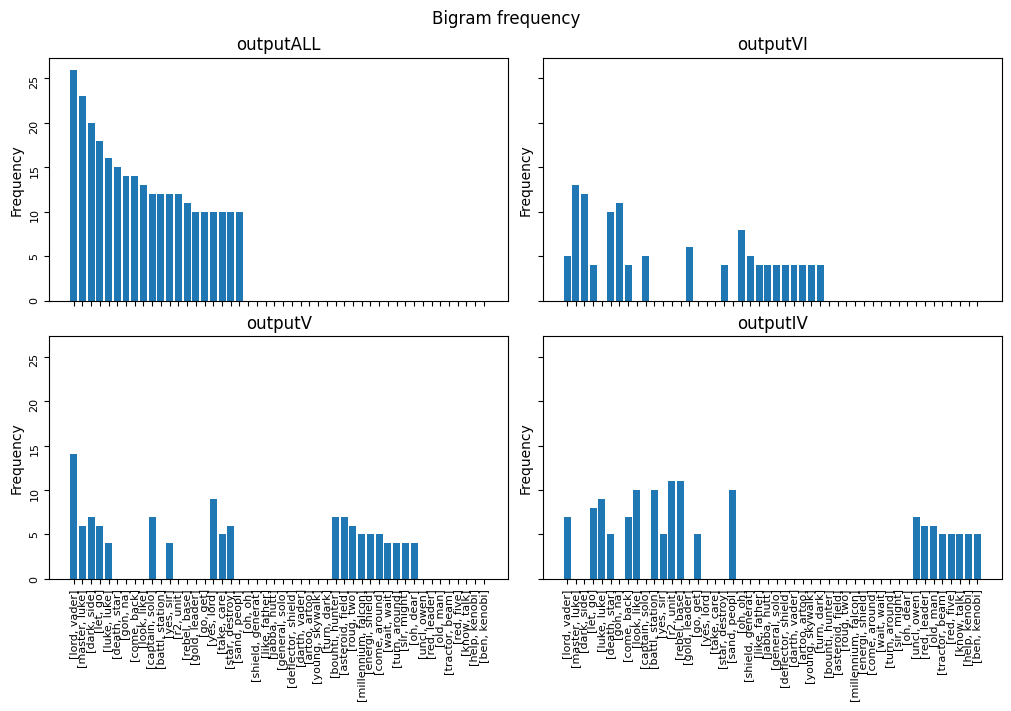

In [216]:
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True, layout="constrained", figsize=(10, 7))

for i in range(len(dfs)):
    axs[i // 2, i % 2].bar(x=dfs[i].Character, height=dfs[i].Counts)
    axs[i // 2, i % 2].set_title(f"{dfs_names[i]}")
    axs[i // 2, i % 2].set_ylabel("Frequency")
    axs[i // 2, i % 2].tick_params(labelrotation=90, labelsize=8)
    
fig.suptitle("Bigram frequency");

In [209]:
from functools import reduce

In [210]:
# Merge by index result of 3 outputs
merged = reduce(
    lambda x, y: pd.merge(x, y, how='outer', left_index=True, right_index=True), 
    [df.set_index('Character').sort_index() for df in dfs[1:]]
).fillna(0)

In [211]:
# Get the 20 most talking for all chapters
merged['Total'] = merged["Counts"] + merged["Counts_x"] + merged["Counts_y"]
all_test = merged.sort_values('Total', ascending=False).Total.values[:20]

In [214]:
merged

,Counts_x,Counts_y,Counts,Total
Character,,,,
"[artoo, artoo]",4.0,0.0,0.0,4.0
"[asteroid, field]",0.0,7.0,0.0,7.0
"[battl, station]",0.0,0.0,10.0,10.0
"[ben, kenobi]",0.0,0.0,5.0,5.0
"[bounti, hunter]",0.0,7.0,0.0,7.0
"[captain, solo]",5.0,7.0,0.0,12.0
"[come, around]",0.0,5.0,0.0,5.0
"[come, back]",4.0,0.0,7.0,11.0
"[dark, side]",12.0,7.0,0.0,19.0


In [212]:
np.equal(dfs[0].Counts.values, all_test)

array([ True, False, False,  True, False, False, False, False, False,
       False, False, False, False, False,  True, False, False, False,
       False, False])